# Quantum Regressor

## Quantum Doctor

### How to train a hybrid-quantum neural network to predict diabetes progression in patients.

In this tutorial you will learn how to create a hybrid neural network, which utilizes a quantum regression layer as its output.  
As our training dataset we will use a subset of the [diabetes toy dataset](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html) available via `scikit-learn`.

## Table of contents:
- [Dataset preparation and exploration](#dataset-preparation)
- [Model creation](#model-creation)
- [Model training and evaluation](#model-evaluation)


In [1]:
import warnings
warnings.simplefilter('ignore')

## Dataset preparation

We can load our dataset via the `load_diabetes` method available from `sklearn.datasets` as it is one of the toy datasets provided by the library.  
You might notice that the $X$ values are already processed. This will save us time.  
We will only use 200 samples from the 442 total, 100 for training and 100 for evaluation.

In [2]:
import pandas as pd
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()

X = pd.DataFrame(diabetes.data[:200],columns=diabetes.feature_names)
y = pd.Series(diabetes.target[:200])

The diabetes dataset consists of 10 numeric variables: age, sex (2 possible values), body mass index (*bmi*), average blood pressure (*bp*), as well as results of six blood serum measurements (described on the [sklearn dataset page](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset)).

In [3]:
X.head(5)

age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  
0 -0.002592  0.019907 -0.017646  
1 -0.039493 -0.068332 -0.092204  
2 -0.002592  0.002861 -0.025930  
3  0.034309  0.022688 -0.009362  
4 -0.002592 -0.031988 -0.046641

The target variable is a quantitative measure of diabetes progression after one year.

In [4]:
y.head(5)

0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
dtype: float64

As usual we will create the training and evaluation subsets using `train_test_split`

In [5]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,random_state=42)

## Model creation

### Quantum layer circuit

A fairly simple QNN architecture will be used for the quantum layer, consisting of one input encoder applied at the beginning and end of the circuit and a RealAmplitudes block for the weights.

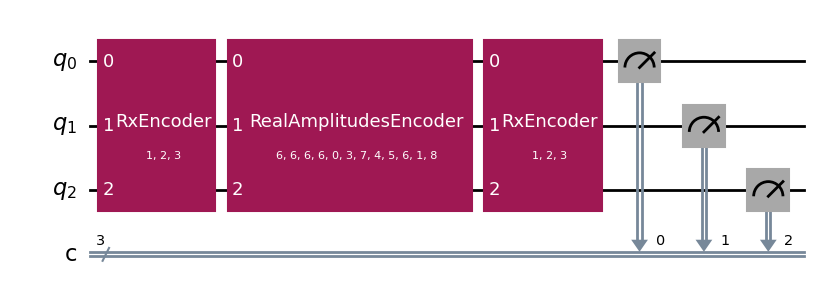

In [6]:
import numpy as np
# QNN library integrating with PyTorch
from qailab.circuit import build_circuit, RotationalEncoder, RealAmplitudesBlock
from qailab.circuit.utils import assign_input_weight

input_encoder = RotationalEncoder('x','input')
qnn_circuit = build_circuit(
    3,
    [
        input_encoder,
        RealAmplitudesBlock('weight'),
        input_encoder, # You can put the same block twice in different parts of the circuit. It will encode the same parameters
    ],
    measure_qubits=[0,1,2] # Measure all qubits
    )

qnn_circuit.assign_parameters(assign_input_weight(qnn_circuit,[1,2,3],np.random.randint(0,9,12))).draw('mpl')

### Sequential neural network

Our neural network will consist of two linear layers with ReLU activation functions, then a quantum layer, which outputs a single feature: the expected value of measurement from it's circuit.  

The expected value of a random variable can be expressed as $E[X] = \sum_{i=0}^{n} P(X == X_i) * X_i$  
Given that our measurement bitstrings can be interpreted as integers, the expected value of a parameterized quantum circuit becomes $E[X] = \sum_{i=0}^{n} |\braket{X_i|U(\theta)|0}|^2 * \text{integer}(X_i)$, where $X_i$ is a given measurement bitstring.  
  
Since we measure all 3 qubits in our QNN circuit, the expected value layer will output a value in the range of $[0,7]$. Our problem needs a higher range of numbers, therefore we will tell `ExpectedValueQLayer` to rescale the output.

In [7]:
# Neural networks libraries
import torch.nn as nn 

from qailab.torch import ExpectedValueQLayer,QModel
from quantum_launcher.routines.qiskit_routines import AerBackend

qlayer = ExpectedValueQLayer(
    qnn_circuit,
    rescale_output=(0,350), # Max target value in dataset + a bit more.
    backend=AerBackend('local_simulator')
    )

sequential_net = nn.Sequential(
    nn.Linear(len(X.columns),64),
    nn.ReLU(),
    nn.Linear(64,qlayer.in_features),
    qlayer,
    
)

model = QModel(
    module=sequential_net,
    loss=nn.L1Loss(), # MAE loss
    optimizer_type='adam',
    learning_rate=0.001,
    batch_size=4,
    validation_fraction=0.1,
    epochs=20,
    metric="mse"
    )

## Model training and results.

### Training

To train our model we can simply call `QModel.fit()`

In [8]:
model.fit(X_train,y_train)
pass

100%|██████████| 20/20 [03:20<00:00, 10.00s/epochs, epoch=20, loss=47.6, mse=3.38e+3]


Below we can see how our model was performing during the 10 epochs of training.

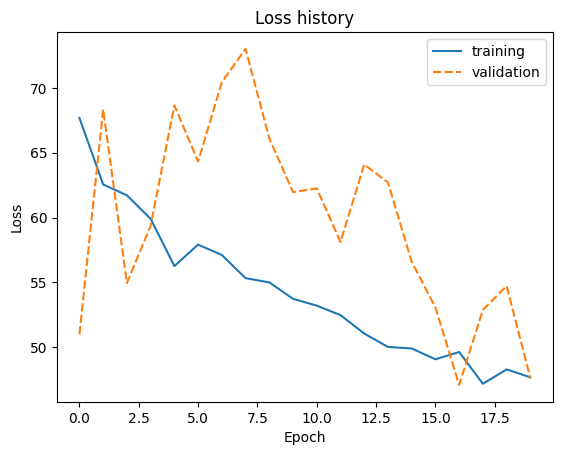

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(model.loss_history)

plt.title('Loss history')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.show()

As a comparison we will also train a similar classical model.

In [10]:
sequential_net_classical = nn.Sequential(
    nn.Linear(len(X.columns),64),
    nn.ReLU(),
    nn.Linear(64,3),
    nn.ReLU(),
    nn.Linear(3,1),
    nn.ReLU()
    
)
model_classical = QModel(
    module=sequential_net_classical,
    loss=nn.L1Loss(), # MAE loss
    optimizer_type='adam',
    learning_rate=0.001,
    batch_size=4,
    validation_fraction=0.1,
    epochs=20,
    metric="mse"
    )

In [11]:
model_classical.fit(X,y)
pass

100%|██████████| 20/20 [00:02<00:00,  8.09epochs/s, epoch=20, loss=132, mse=97595.0]


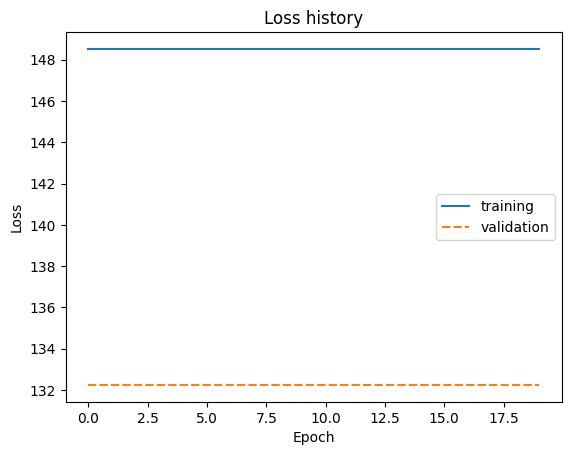

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(model_classical.loss_history)

plt.title('Loss history')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.show()

### Model evaluation

Let's compare the performance of our models on the test dataset.

In [13]:
from sklearn.metrics import mean_absolute_error

classical_predictions = model_classical.predict(X_test)
quantum_predictions = model.predict(X_test)

print(f"Classical model error: {mean_absolute_error(classical_predictions,y_test)}")
print(f"Hybrid model error: {mean_absolute_error(quantum_predictions,y_test)}")

Classical model error: 152.19
Hybrid model error: 46.13027381896973
